In [1]:

import argparse

from bigmdp.data.dataset import SimpleReplayBuffer, gather_data_in_buffer
from bigmdp.data.frozen_lake import FrozenLakeEnvDynamic, save_and_print_results
from bigmdp.data.frozen_lake import evaluate_policy_discounted
from bigmdp.mdp.MDP_GPU import FullMDP
from bigmdp.mdp.vi_engine_s import simple_value_iteration
from bigmdp.utils.tmp_vi_helper import *
from bigmdp.utils.utils_directory import * 

In [2]:

ENV_MAP = {"frozen_lake": FrozenLakeEnvDynamic}
VI_ENGINE_MAP = { 'simple': simple_value_iteration}


parser = argparse.ArgumentParser()
parser.add_argument('-e', "--env_name", help="Choice of Environment to solve",
                    choices=['frozen_lake'], default='frozen_lake')
parser.add_argument('-exp_id', "--experiment_id", help="Experiment id for new result folder", default='R1')
parser.add_argument('-vi', "--vi_engine", help="Choice of VI engine to use",
                    choices=['distributed', 'simple'], default='simple')
parser.add_argument("-w", "--workers", help="Number of Workers", type=int, default=4)
parser.add_argument("-m", "--map_size", help="map size(s), comma separated", default=100)
parser.add_argument("--load_env", help="load environment from cache ?", action="store_true", default=True)
parser.add_argument("--verbose", help="print errors", action="store_true", default=False)
parser.add_argument("-r", "--num_of_runs", help="Number of full pipeline runs", type=int, default=10)
args = parser.parse_args("-e frozen_lake".split(" "))

map_sizes = [14] # [int(i) for i in args.map_size.split(',')]  # [10, 32, 72, 100, 225, 320, 500, 708, 868, 1000]


In [3]:
args.map_size = 8

In [4]:
# House Keeping
results_dir = "results/" + str(args.env_name) +"_" +str(args.experiment_id)+"/"
create_hierarchy(results_dir)

# Define Environment
Env = ENV_MAP[args.env_name]
full_map_size = (args.map_size, args.map_size)
env = Env(full_map_size)


In [5]:
env._env

_ENV(observation_space=array([1]))

In [6]:
params = {"unknown_transition_reward":-2000,
         "gamma":0.99,
         "slip_probability":0.1,
         "rmax_reward":1000,
         "rmax_thres":10,
         "balanced_explr":False,
         "rmin" :-2000}


In [7]:
train_buffer =  SimpleReplayBuffer(int(1e5))


# Collect random Dataset # till replay initial\
random_policy = lambda s: env.sample_random_action()
train_buffer, info = gather_data_in_buffer(train_buffer, env, episodes=9999, render=False, policy=random_policy,
                                           frame_count=500000, pad_attribute_fxn={"qval": lambda s: 0})

        


Average Reward of collected trajectories:-114.381


In [9]:
#Make MDP
mdp_T = FullMDP(A=env.get_list_of_actions(),
              ur=params["unknown_transition_reward"],
              vi_params={"gamma": params["gamma"],
                         "slip_prob": params["slip_probability"],
                         "rmax_reward": params["rmax_reward"],
                         "rmax_thres": 2,
                         "balanced_explr": True,
                         "rmin": params["rmin"]},
              policy_params={"unhash_array_len": env._env.observation_space.shape[0]},
              MAX_S_COUNT=int(1e4),
              weight_transitions=True,
              default_mode="GPU")

# Populate your MDP
mdp_T = populate_model_from_buffer(mdp_T, train_buffer, lambda s:s)

100%|██████████| 391/391 [00:12<00:00, 32.58it/s]


In [10]:
mdp_T.solve(1e-1,mode="GPU")

Time takedn to solve 1.8479840755462646


In [11]:
val_vector = [-1000]*env.GetStateSpace()
pi_vector = [0]*env.GetStateSpace()
for i in list(range(env.GetStateSpace())):
    s = str([i])
    if s in mdp_T.valueDict:
        val_vector[i] = float(mdp_T.valueDict[s][0])
        pi_vector[i] = int(mdp_T.polDict[s])

In [12]:
evaluate_policy_discounted(env,pi_vector, 0.99, trials=100)

549.035376273327


Average reward: 544.4

Avereage discounted reward: 620.5319554171218

State Value image view:



Best Q-value and Policy:



(544.4, 620.5319554171218)

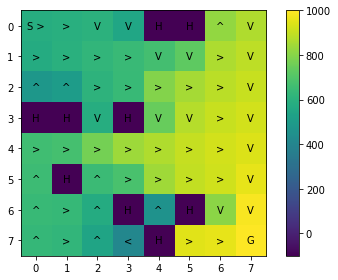

In [13]:

# Process Results and Add to plot
save_and_print_results(val_vector, pi_vector, MAP=env.map_grid, env=env, beta=0.99, name=args.vi_engine, results_dir=results_dir)